# Import Packages and Dataset

## Packages

In [1]:
!pip install transformers

In [0]:
%tensorflow_version 2.x

In [3]:
import torch
import transformers as tfm # pytorch transformers
from sklearn.linear_model import LogisticRegression

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import InputLayer

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,hamming_loss

from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import pickle

from tqdm import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Dataset

In [4]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
train_path = '/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Data/data_train_nostemstop_preprocessed.csv'

data_train = pd.read_csv(train_path,sep=";")

In [6]:
data_train.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,- kdg will be kind enough to show you how to l...,0,1,0,0,0,0,0,0,0,0,0,0,kadang will be kind enough to show you how to...
1,Ternyata komunis juga bisa nangis',0,0,0,0,0,0,0,0,0,0,0,0,ternyata komunis juga bisa menangis
2,USER USER Kenapa harus bom ya? Kek yg benar nu...,0,0,0,0,0,0,0,0,0,0,0,0,user user kenapa harus bom seperti benar men...
3,USER Sumpaaah kaya kalo abis IAA dilanjut olim...,0,0,0,0,0,0,0,0,0,0,0,0,user sumpah kaya kalau habis iya dilanjut olim...
4,RT USER USER USER USER USER fungsi media sosia...,1,0,1,0,0,0,0,0,1,1,0,0,rt user user user user user fungsi media sosia...


In [0]:
test_path = '/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Data/data_test_nostemstop_preprocessed.csv'

data_test = pd.read_csv(test_path,sep=";")

In [8]:
data_test.head()

,Index,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,1,GANTENG TAPI BERENGSEK!!! BUAT APA?!!\nWHO DO ...,1,1,1,0,0,0,0,0,1,1,0,0,ganteng tapi berengsek buat apa who do you thi...
1,2,Sakit jiwa kali yah..,0,0,0,0,0,0,0,0,0,0,0,0,sakit jiwa kali
2,3,"Does insulting one for being ""Cina"", ""Kafir"", ...",0,1,0,0,0,0,0,0,0,0,0,0,does insulting one for being cina kafir make y...
3,4,USER USER Karena partaimu pdip itu bajingan',1,1,0,1,0,0,0,0,1,0,1,0,user user karena partaimu partai demokrasi ind...
4,5,USER USER Jgn salah itu janji jokowi yg di tun...,1,1,1,0,0,0,0,0,1,1,0,0,user user jangan salah itu janji jokowi di tu...


In [0]:
val_path = '/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Data/data_val_nostemstop_preprocessed.csv'

data_val = pd.read_csv(val_path,sep=";")

In [10]:
data_val.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,So much berengsek people in the world,1,1,0,1,0,0,0,0,1,0,1,0,so much berengsek people in the world
1,"So, how can I get my REKBER?? rekening berengsek.",0,1,0,0,0,0,0,0,0,0,0,0,so how can i get my rekening berengsek rekenin...
2,RT USER: dasar bajingan!\xf0\x9f\x98\xa0 URL,0,1,0,0,0,0,0,0,0,0,0,0,rt user dasar bajingan url
3,USER Krn cebong tdk akn mengakui pria lajang y...,1,1,0,1,0,0,0,0,1,0,1,0,user karena kecebong tidak akan mengakui pria ...
4,"RT USER: ga ada urusannya, monyet. gua broken ...",1,1,1,0,0,0,0,0,1,1,0,0,rt user tidak ada urusannya monyet aku broken ...


# Features Target Split

In [0]:
X_train = data_train['Tweet_Parsed']
y_train = data_train.drop(['Tweet','Tweet_Parsed'],axis=1).values

X_val = data_val['Tweet_Parsed']
y_val = data_val.drop(['Tweet','Tweet_Parsed'],axis=1).values

X_test = data_test['Tweet_Parsed']
y_test = data_test.drop(['Tweet','Tweet_Parsed','Index'],axis=1).values

# DistilBert Model

In [0]:
model_class, tokenizer_class, pretrained_weights = (tfm.DistilBertModel, tfm.DistilBertTokenizer, 'distilbert-base-multilingual-cased')

## Load Tokenizer and Model

In [0]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

## Tokenize Train Set, Validation Set, and Test Set

In [0]:
train_sequences = X_train.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [0]:
validation_sequences = X_val.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [0]:
test_sequences = X_test.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [0]:
train_padded = sequence.pad_sequences(train_sequences, maxlen=100, padding="post", truncating="post")

In [0]:
validation_padded = sequence.pad_sequences(validation_sequences, maxlen=100, padding="post", truncating="post")

In [0]:
test_padded = sequence.pad_sequences(test_sequences, maxlen=100, padding="post", truncating="post")

## Change Padded to Tensor and Run Model (Forward Pass)

In [0]:
train_ids = torch.tensor(np.array(train_padded)).to(torch.int64)
train_features = []
batch_size = 200
for batch in tqdm(range(0,len(train_ids),batch_size)):
  with torch.no_grad():
    train_last_hidden_states = model(train_ids[batch:batch+batch_size])
    train_features.append(train_last_hidden_states[0])
# train_features = train_features.numpy()

100%|██████████| 67/67 [15:34<00:00, 13.95s/it]


In [0]:
train_features = np.concatenate(train_features)

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_train_nostemstop_3d.pkl', 'wb') as f:
  pickle.dump(train_features, f)

with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_y_train_nostemstop_3d.pkl', 'wb') as f:
  pickle.dump(y_train, f)

In [0]:
validation_ids = torch.tensor(np.array(validation_padded)).to(torch.int64)
validation_features = []
batch_size = 200
for batch in tqdm(range(0,len(validation_ids),batch_size)):
  with torch.no_grad():
    validation_last_hidden_states = model(validation_ids[batch:batch+batch_size])
    validation_features.append(validation_last_hidden_states[0])

100%|██████████| 8/8 [01:46<00:00, 13.35s/it]


In [0]:
validation_features = np.concatenate(validation_features)

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_validation_nostemstop_3d.pkl', 'wb') as f:
  pickle.dump(validation_features, f)

with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_y_validation_nostemstop_3d.pkl', 'wb') as f:
  pickle.dump(y_val, f)

In [0]:
test_ids = torch.tensor(np.array(test_padded)).to(torch.int64)
test_features = []
batch_size = 200
for batch in tqdm(range(0,len(test_ids),batch_size)):
  with torch.no_grad():
    test_last_hidden_states = model(test_ids[batch:batch+batch_size])
    test_features.append(test_last_hidden_states[0])

100%|██████████| 19/19 [04:11<00:00, 13.26s/it]


In [0]:
test_features = np.concatenate(test_features)

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_test_nostemstop_3d.pkl', 'wb') as f:
  pickle.dump(test_features, f)

with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_y_test_nostemstop_3d.pkl', 'wb') as f:
  pickle.dump(y_test, f)

In [0]:
while 1:
  print("",end="")

KeyboardInterrupt: ignored

In [0]:
train_features.shape

(13244, 100, 768)

In [0]:
validation_features.shape

(1472, 100, 768)

In [0]:
test_features.shape

(3680, 100, 768)

# Classification

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_train_nostemstop_3d.pkl', 'rb') as f:
  train_features = pickle.load(f)

with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_y_train_nostemstop_3d.pkl', 'rb') as f:
  y_train = pickle.load(f)

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_validation_nostemstop_3d.pkl', 'rb') as f:
  validation_features = pickle.load(f)

with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_y_validation_nostemstop_3d.pkl', 'rb') as f:
  y_validation = pickle.load(f)

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_test_nostemstop_3d.pkl', 'rb') as f:
  test_features = pickle.load(f)

with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_y_test_nostemstop_3d.pkl', 'rb') as f:
  y_test = pickle.load(f)

## Define Model

In [17]:
model = Sequential()
# Configuring the parameters
model.add(InputLayer((100,768)))
model.add(Conv1D(128,5, activation="relu"))
model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation="relu"))
model.add(Dense(12, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 96, 128)           491648    
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                780       
Total params: 500,684
Trainable params: 500,684
Non-trainable params: 0
_________________________________________________________________


## Training Model with Adam Optimizer

In [18]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(train_features, y_train, 
                    validation_data=(validation_features, y_val),
                    epochs=80, batch_size=32, 
                    verbose=2)

Epoch 1/80
414/414 - 3s - loss: 0.3628 - accuracy: 0.5328 - val_loss: 0.3448 - val_accuracy: 0.4355
Epoch 2/80
414/414 - 3s - loss: 0.3382 - accuracy: 0.5403 - val_loss: 0.3432 - val_accuracy: 0.3519
Epoch 3/80
414/414 - 3s - loss: 0.3283 - accuracy: 0.5335 - val_loss: 0.3306 - val_accuracy: 0.4450
Epoch 4/80
414/414 - 3s - loss: 0.3228 - accuracy: 0.5204 - val_loss: 0.3232 - val_accuracy: 0.5265
Epoch 5/80
414/414 - 3s - loss: 0.3150 - accuracy: 0.5226 - val_loss: 0.3175 - val_accuracy: 0.4484
Epoch 6/80
414/414 - 3s - loss: 0.3100 - accuracy: 0.5220 - val_loss: 0.3248 - val_accuracy: 0.5102
Epoch 7/80
414/414 - 3s - loss: 0.3058 - accuracy: 0.5180 - val_loss: 0.3274 - val_accuracy: 0.3573
Epoch 8/80
414/414 - 3s - loss: 0.3026 - accuracy: 0.5062 - val_loss: 0.3083 - val_accuracy: 0.5292
Epoch 9/80
414/414 - 3s - loss: 0.2995 - accuracy: 0.5210 - val_loss: 0.3052 - val_accuracy: 0.4980
Epoch 10/80
414/414 - 3s - loss: 0.2965 - accuracy: 0.4974 - val_loss: 0.3146 - val_accuracy: 0.5510

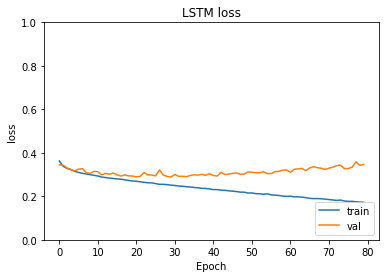

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['train', 'val'], loc='lower right')
plt.show()

## Predict and Result

In [0]:
predict = model.predict(test_features)
predict_train = model.predict(train_features)
predict_val = model.predict(validation_features)
thresholds=0.5

In [0]:
def labelSetAccuracy(y_true, y_pred):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
#         print('\nset_true: {0}'.format(set_true))
#         print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [23]:
pred_test = predict.copy()
pred_test[pred_test>=0.5] = 1
pred_test[pred_test<0.5] = 0
acc = accuracy_score(y_test,pred_test)
haml_loss = hamming_loss(y_test,pred_test)
label_acc = labelSetAccuracy(y_test,pred_test)
print("threshold = ",thresholds)
print("exact accuracy = ", acc)
print("hamming loss = ",haml_loss)
print("label based accuracy = ",label_acc)
print("==============================")

threshold =  0.5
exact accuracy =  0.49483695652173915
hamming loss =  0.12051630434782609
label based accuracy =  0.6130209411663217


In [24]:
pred_train = predict_train.copy()
pred_train[pred_train>=0.5] = 1
pred_train[pred_train<0.5] = 0
acc = accuracy_score(y_train,pred_train)
haml_loss = hamming_loss(y_train,pred_train)
label_acc = labelSetAccuracy(y_train,pred_train)
print("threshold = ",thresholds)
print("exact accuracy = ", acc)
print("hamming loss = ",haml_loss)
print("label based accuracy = ",label_acc)
print("==============================")


threshold =  0.5
exact accuracy =  0.6535789791603746
hamming loss =  0.06769102990033223
label based accuracy =  0.7704786354288016


In [25]:
pred_val = predict_val.copy()
pred_val[pred_val>=0.5] = 1
pred_val[pred_val<0.5] = 0
acc = accuracy_score(y_val,pred_val)
haml_loss = hamming_loss(y_val,pred_val)
label_acc = labelSetAccuracy(y_val,pred_val)
print("threshold = ",thresholds)
print("exact accuracy = ", acc)
print("hamming loss = ",haml_loss)
print("label based accuracy = ",label_acc)
print("==============================")


threshold =  0.5
exact accuracy =  0.499320652173913
hamming loss =  0.12126358695652174
label based accuracy =  0.6234180900621118


## Save Model

In [0]:
model.save('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Model/modeldistilBERT_nostemstop.h5')

In [0]:
from tensorflow.keras.models import load_model
model = load_model('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Model/modeldistilBERT_nostemstop.h5')

# Analysis Predict

In [0]:
target = data_train.columns[1:-1]

## Data Validation Predict Analysis

In [0]:
data_val = pd.DataFrame(data=X_val,columns=['Tweet_Parsed']).reset_index(drop=True).join(pd.DataFrame(y_val,columns=target)).reset_index(drop=True)

In [28]:
data_val.head()

,Tweet_Parsed,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,so much berengsek people in the world,1,1,0,1,0,0,0,0,1,0,1,0
1,so how can i get my rekening berengsek rekenin...,0,1,0,0,0,0,0,0,0,0,0,0
2,rt user dasar bajingan url,0,1,0,0,0,0,0,0,0,0,0,0
3,user karena kecebong tidak akan mengakui pria ...,1,1,0,1,0,0,0,0,1,0,1,0
4,rt user tidak ada urusannya monyet aku broken ...,1,1,1,0,0,0,0,0,1,1,0,0


In [0]:
data_val_predict = pd.DataFrame(data=X_val,columns=['Tweet_Parsed']).reset_index(drop=True).join(pd.DataFrame(data=pred_val, columns=target))

In [30]:
data_val_predict.head()

,Tweet_Parsed,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,so much berengsek people in the world,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,so how can i get my rekening berengsek rekenin...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,rt user dasar bajingan url,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,user karena kecebong tidak akan mengakui pria ...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,rt user tidak ada urusannya monyet aku broken ...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Check Number of Label on Predict Data

In [0]:
label_size0_val = []
label_size1_val = []

for i in data_val.columns[1:]:
    label_size0_val.append(len(data_val[data_val[i]==0]))
    label_size1_val.append(len(data_val[data_val[i]==1]))

label_size0_val_predict = []
label_size1_val_predict = []

for i in data_val_predict.columns[1:]:
    label_size0_val_predict.append(len(data_val_predict[data_val_predict[i]==0]))
    label_size1_val_predict.append(len(data_val_predict[data_val_predict[i]==1]))

In [0]:
dat_anls_val = pd.DataFrame({
    'label' : data_val.columns[1:],
    'stats' : ["negative" for i in range(len(data_val.columns[1:]))],
    'jumlah' : label_size0_val
}).append(
    pd.DataFrame({
        'label' : data_val.columns[1:],
        'stats' : ["positive" for i in range(len(data_val.columns[1:]))],
        'jumlah' : label_size1_val
    })
)

# dat_anls_val = dat_anls_val.set_index(['label'], drop=True)

dat_anls_val_predict = pd.DataFrame({
    'label' : data_val_predict.columns[1:],
    'stats' : ["negative" for i in range(len(data_val_predict.columns[1:]))],
    'jumlah' : label_size0_val_predict
}).append(
    pd.DataFrame({
        'label' : data_val_predict.columns[1:],
        'stats' : ["positive" for i in range(len(data_val_predict.columns[1:]))],
        'jumlah' : label_size1_val_predict
    })
)

# dat_anls_val_predict = dat_anls_val_predict.set_index(['label'], drop=True)

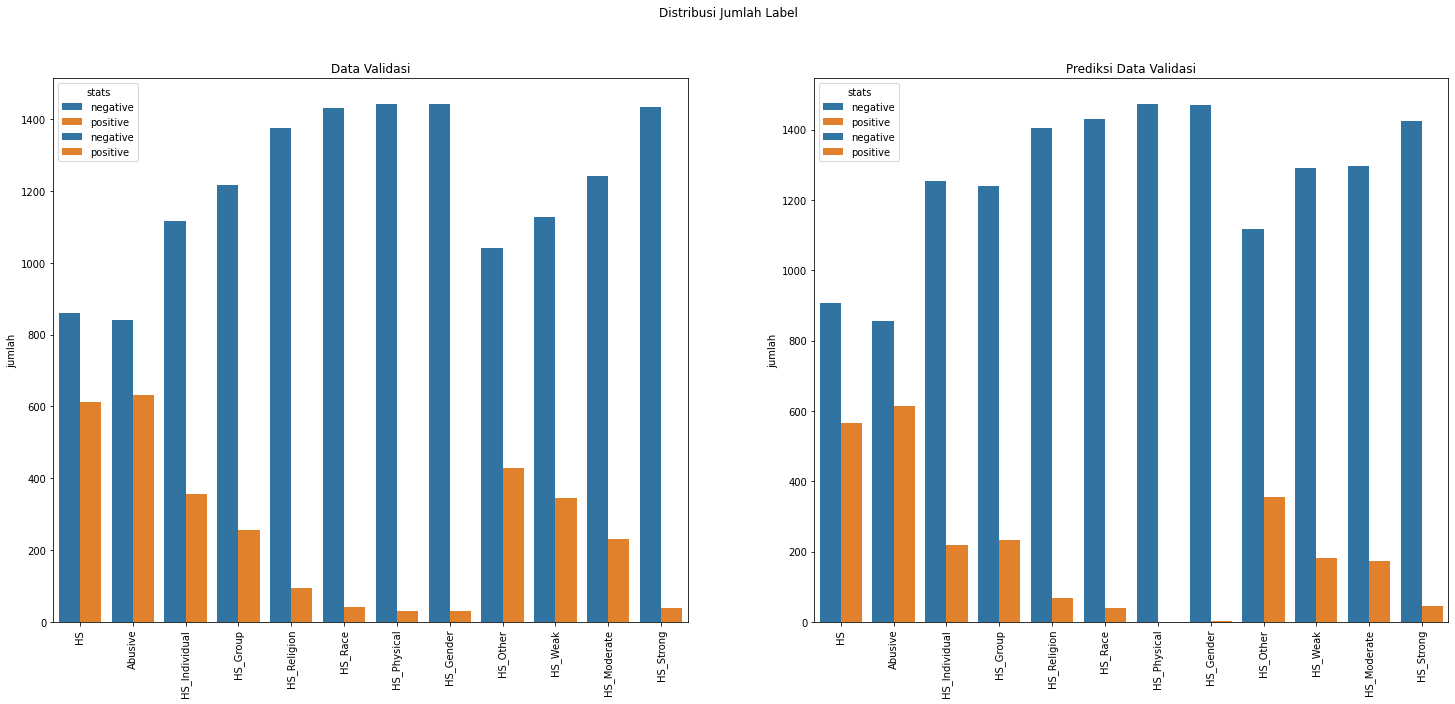

In [33]:
plt.figure(figsize=(25,10))
plt.suptitle('Distribusi Jumlah Label')

plt.subplot(1,2,1)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val).get_xticklabels(),rotation=90)
plt.title("Data Validasi")
plt.xlabel('')

plt.subplot(1,2,2)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val_predict).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val_predict).get_xticklabels(),rotation=90)
plt.title("Prediksi Data Validasi")
plt.xlabel('')

plt.show()

In [34]:
pd.DataFrame({
    "label" : data_val.columns[1:],
    "negative (true)" : dat_anls_val[dat_anls_val['stats'] == "negative"]["jumlah"].values,
    "positive (true)" : dat_anls_val[dat_anls_val['stats'] == "positive"]["jumlah"].values,
    "negative (predict)" : dat_anls_val_predict[dat_anls_val_predict['stats'] == "negative"]["jumlah"].values,
    "positive (predict)" : dat_anls_val_predict[dat_anls_val_predict['stats'] == "positive"]["jumlah"].values
})

,label,negative (true),positive (true),negative (predict),positive (predict)
0,HS,859,613,906,566
1,Abusive,840,632,857,615
2,HS_Individual,1115,357,1253,219
3,HS_Group,1216,256,1240,232
4,HS_Religion,1376,96,1405,67
5,HS_Race,1431,41,1431,41
6,HS_Physical,1441,31,1472,0
7,HS_Gender,1441,31,1469,3
8,HS_Other,1042,430,1117,355
9,HS_Weak,1128,344,1290,182


### OOV Check

In [0]:
def generate_ngrams(s):
    
    # Break sentence in the token, remove empty tokens
    tokens = [token for token in s.str.split(" ") if token != ""]
    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = np.concatenate(tokens)
    return ngrams

def oov(fitur,token):
    outOfVocab = []
    for i in token:
        if i not in fitur:
            outOfVocab.append(i)
    return outOfVocab

def oov_count(oovList):
    oovCount = {}
    for i in oovList:
        if i in oovCount.keys():
            oovCount[i] = oovCount[i]+1
        else:
            oovCount[i] = 1
    return oovCount

In [0]:
join_data_val = data_val.join(data_val_predict.drop(['Tweet_Parsed'],axis=1),rsuffix="_predict")

In [0]:
miss_exact_tweet_val = join_data_val[(join_data_val["HS"]!=join_data_val["HS_predict"]) | (join_data_val["Abusive"] != join_data_val["Abusive_predict"]) | (join_data_val["HS_Individual"] != join_data_val["HS_Individual_predict"]) | (join_data_val["HS_Group"] != join_data_val["HS_Group_predict"]) | (join_data_val["HS_Religion"] != join_data_val["HS_Religion_predict"]) | (join_data_val["HS_Race"] != join_data_val["HS_Race"]) | (join_data_val["HS_Physical"] != join_data_val["HS_Physical_predict"]) | (join_data_val["HS_Gender"] != join_data_val["HS_Gender_predict"]) | (join_data_val["HS_Other"] != join_data_val["HS_Other_predict"]) | (join_data_val["HS_Weak_predict"] != join_data_val["HS_Weak_predict"]) | (join_data_val["HS_Moderate_predict"] != join_data_val["HS_Moderate_predict"]) | (join_data_val["HS_Strong_predict"] != join_data_val["HS_Strong_predict"])]

In [0]:
vocab = tokenizer.ids_to_tokens.values()

In [39]:
tokenizer.ids_to_tokens.values()

odict_values(['[PAD]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[unused31]', '[unused32]', '[unused33]', '[unused34]', '[unused35]', '[unused36]', '[unused37]', '[unused38]', '[unused39]', '[unused40]', '[unused41]', '[unused42]', '[unused43]', '[unused44]', '[unused45]', '[unused46]', '[unused47]', '[unused48]', '[unused49]', '[unused50]', '[unused51]', '[unused52]', '[unused53]', '[unused54]', '[unused55]', '[unused56]', '[unused57]', '[unused58]', '[unused59]', '[unused60]', '[unused61]', '[unused62]', '[unused63]', '[unused64]', '[unused65]', '[unused66]', '[unused67]', '[unused68]', '[unused69]', '[unused70]', '[unus

In [0]:
oov_val = oov(vocab, generate_ngrams(miss_exact_tweet_val['Tweet_Parsed']))
oov_val_count = oov_count(oov_val)

In [41]:
oov_val_count

{'berengsek': 11,
 'rt': 38,
 'bajingan': 11,
 'urusannya': 1,
 'monyet': 9,
 'dipukuli': 1,
 '': 1023,
 'ampun': 1,
 'rupiah': 6,
 'banget': 20,
 'celeng': 2,
 'buat': 26,
 'synna': 1,
 'emosi': 1,
 'jangan': 24,
 'mancing': 1,
 'malaysia': 61,
 'infinit': 1,
 'tunggu': 2,
 'timnas': 3,
 'shame': 39,
 'sinting': 2,
 'minum': 3,
 'obat': 1,
 'angkat': 1,
 'banyuwangi': 1,
 'kunci': 1,
 'kesuksesan': 1,
 'bec': 1,
 'bacot': 7,
 'kalian': 17,
 'bahas': 2,
 'merusak': 3,
 'penguatan': 1,
 'revitalisasi': 1,
 'baca': 5,
 'hadisnya': 1,
 'pensyariatan': 1,
 'puasa': 2,
 'asyura': 1,
 'akikah': 1,
 'ittiba': 2,
 'ikuti': 1,
 'yahudi': 14,
 'sahabat': 2,
 'sunnah': 1,
 'nabi': 5,
 'gamis': 1,
 'hukumnya': 1,
 'mubah': 1,
 'sarung': 1,
 'peci': 1,
 'sendu': 1,
 'gila': 14,
 'menonton': 6,
 'tuan': 5,
 'bajang': 5,
 'mengkritik': 1,
 'itulah': 3,
 'santun': 1,
 'menyakiti': 1,
 'maksudkan': 1,
 'kucing': 2,
 'joke': 5,
 'laughing': 2,
 'bangsat': 29,
 'expect': 2,
 'fuck': 39,
 'munafik': 21,
 

In [42]:
print("number of OOV words : ", len(oov_val))
print("number of unique OOV words : ", len(oov_val_count))

number of OOV words :  5848
number of unique OOV words :  2229


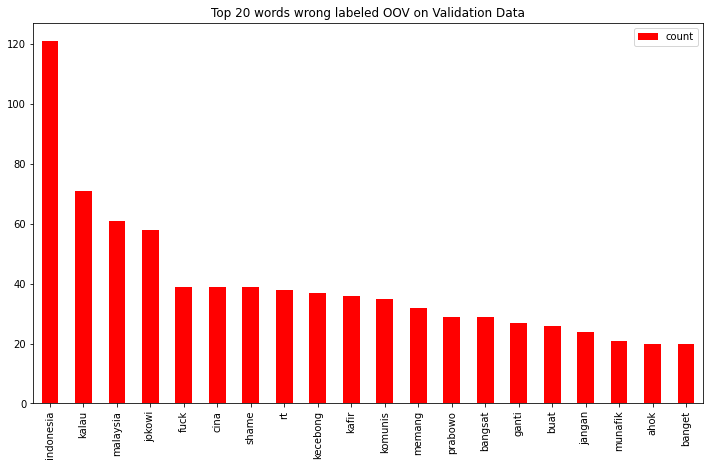

In [43]:
df_oov_val = pd.DataFrame(oov_val_count.items(),columns=["Tweet","count"])
df_oov_val.sort_values(['count'],ascending=False)[1:21].plot(
    kind='bar', y='count',x='Tweet', color='red', title='Top 20 words wrong labeled OOV on Validation Data', figsize=(12,7))
plt.xlabel("")
plt.show()

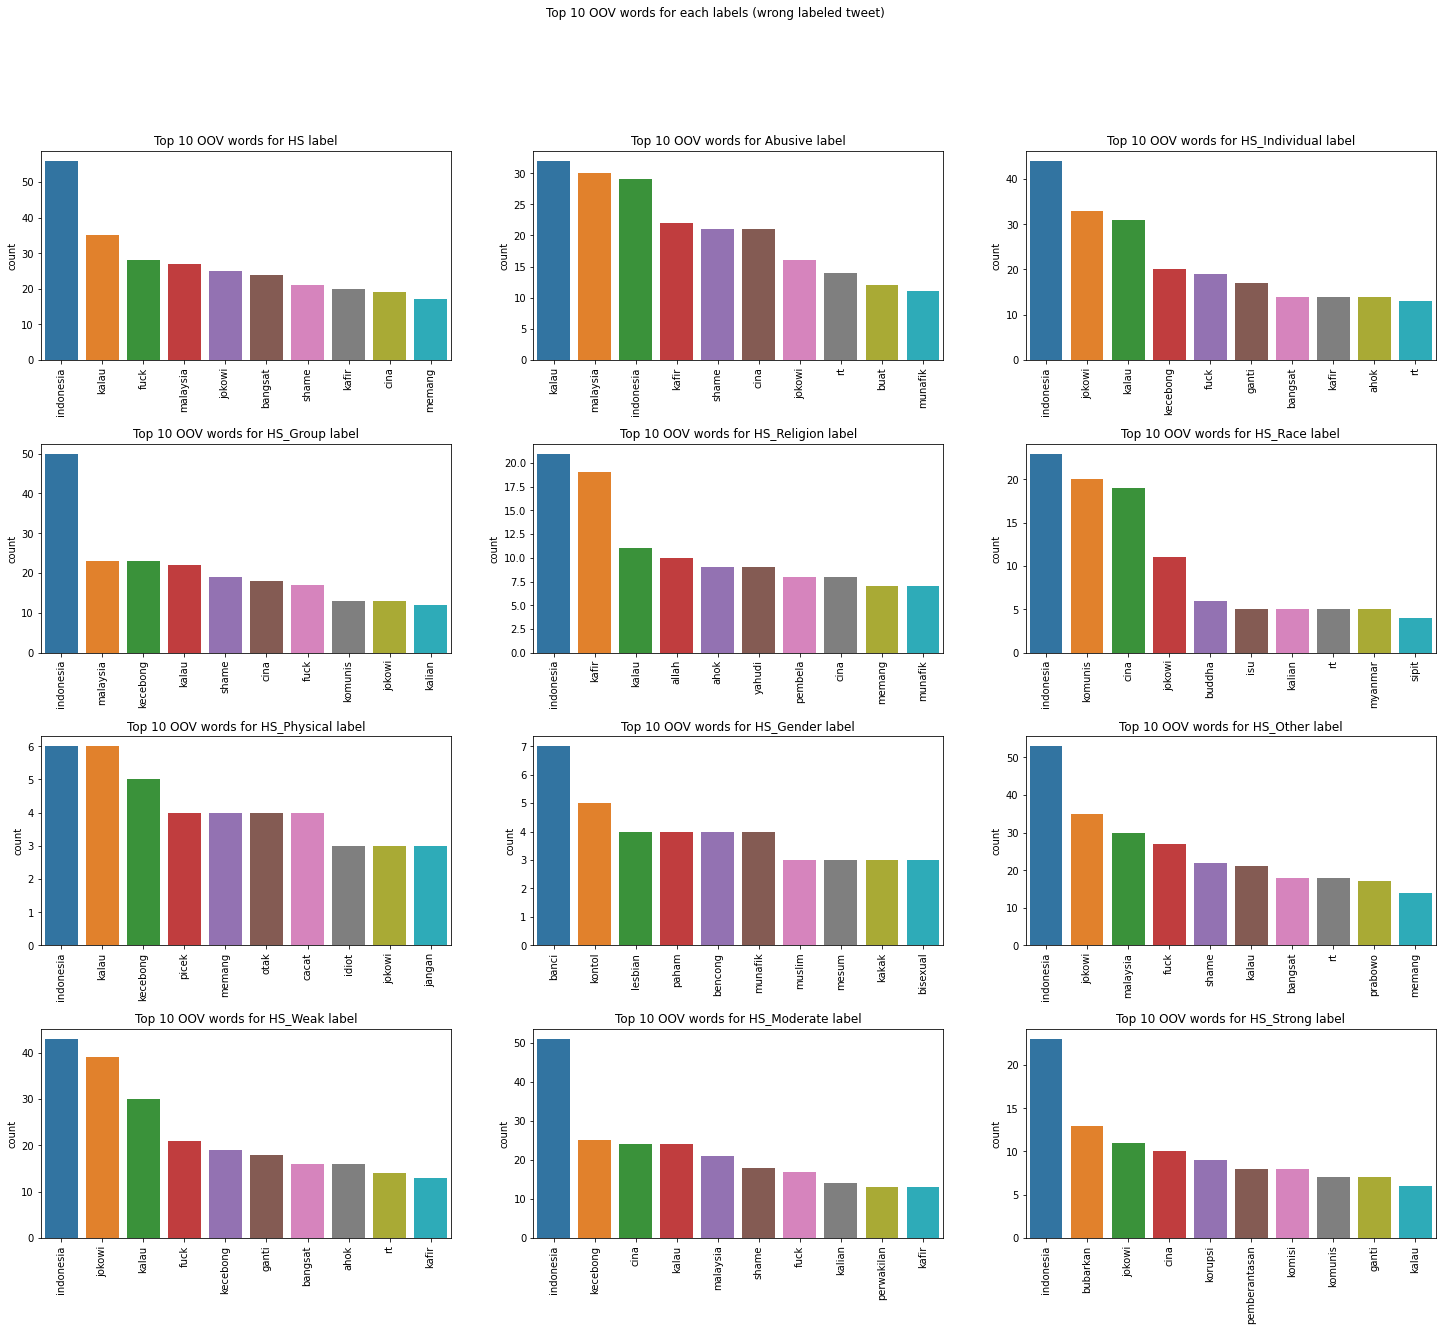

In [44]:

plt.figure(figsize=(25,20))
plt.suptitle('Top 10 OOV words for each labels (wrong labeled tweet)')
for i in range (len(target)):
    plt.subplot(4,3,i+1)
    plt.subplots_adjust(hspace=0.4)
    wrongtweet = join_data_val[join_data_val[target[i]]!=join_data_val[target[i]+str("_predict")]]
    wrongtoken = generate_ngrams(wrongtweet['Tweet_Parsed']).tolist()
    wrong_oov = oov(vocab, wrongtoken)
    wrong_oov_count = oov_count(wrong_oov)
    frame = pd.DataFrame(wrong_oov_count.items(),columns=["Tweet","count"])
    frame = frame.sort_values(['count'],ascending=False)[1:11]
    sns.barplot(x="Tweet", y="count", data=frame).set_xticklabels(sns.barplot(x="Tweet", y="count", data=frame).get_xticklabels(),rotation=90)
    title='Top 10 OOV words for '+str(target[i])+" label"
    plt.title(title)
    plt.xlabel("")

### Tweet Check

In [45]:
miss_exact_tweet_val['Tweet_Parsed'].values.tolist()

['so much berengsek people in the world',
 'rt user dasar bajingan url',
 'rt user tidak ada urusannya monyet aku broken home tidak begitu begitu amat malah dipukuli sama teman teman aku  kaya raya tidak ada tidak ada h ',
 'rt user  tai  tidak ada  mau join tag closed agency basic ',
 ' ampun ini rupiah asing banget kepada ',
 'user user aku lagi celeng tidak buat synna emosi jangan mancing  ',
 'malaysia being defeated infinit  tunggu timnas day shame on you malaysia',
 'sinting kamu sana minum obat url',
 'angkat tradisi dan budaya rakyat banyuwangi kunci kesuksesan bec ',
 'user user bacot  kalian ',
 'bahas islam merusak nilai user penguatan karakter melalui revitalisasi pendidikan nilai',
 'user user baca lagi hadisnya  benar pensyariatan puasa asyura akikah bukan karena ittiba ikuti ajaran yahudi dan adat arab tapi karena para sahabat ittiba sunnah nabi gamis itu hukumnya mubah seperti sarung peci koko tidak a',
 'sendu gila rasa ',
 'user user user pernah menonton bagaimana tua

In [46]:
miss_exact_tweet_val.iloc[:,1:-12].columns

Index(['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race',
       'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate',
       'HS_Strong'],
      dtype='object')

In [47]:
miss_exact_tweet_val.iloc[:,-12:].values.tolist()

[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
 [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
 [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

## Data Test Predict Analysis

In [0]:
data_test_predict = pd.DataFrame(data=data_test['Tweet'],columns=['Tweet']).reset_index(drop=True).join(pd.DataFrame(data=pred_test, columns=target)).join(pd.DataFrame(data=data_test['Tweet_Parsed'],columns=['Tweet_Parsed']).reset_index(drop=True))

### Check Number of Label on Predict Data

In [0]:
label_size0_test = []
label_size1_test = []

for i in data_test.columns[2:-1]:
    label_size0_test.append(len(data_test[data_test[i]==0]))
    label_size1_test.append(len(data_test[data_test[i]==1]))

label_size0_test_predict = []
label_size1_test_predict = []

for i in data_test_predict.columns[1:-1]:
    label_size0_test_predict.append(len(data_test_predict[data_test_predict[i]==0]))
    label_size1_test_predict.append(len(data_test_predict[data_test_predict[i]==1]))

In [0]:
dat_anls_test = pd.DataFrame({
    'label' : data_test.columns[2:-1],
    'stats' : ["negative" for i in range(len(data_test.columns[2:-1]))],
    'jumlah' : label_size0_test
}).append(
    pd.DataFrame({
        'label' : data_test.columns[2:-1],
        'stats' : ["positive" for i in range(len(data_test.columns[2:-1]))],
        'jumlah' : label_size1_test
    })
)

# dat_anls_test = dat_anls_test.set_index(['label'], drop=True)

dat_anls_test_predict = pd.DataFrame({
    'label' : data_test_predict.columns[1:-1],
    'stats' : ["negative" for i in range(len(data_test_predict.columns[1:-1]))],
    'jumlah' : label_size0_test_predict
}).append(
    pd.DataFrame({
        'label' : data_test_predict.columns[1:-1],
        'stats' : ["positive" for i in range(len(data_test_predict.columns[1:-1]))],
        'jumlah' : label_size1_test_predict
    })
)

# dat_anls_test_predict = dat_anls_test_predict.set_index(['label'], drop=True)

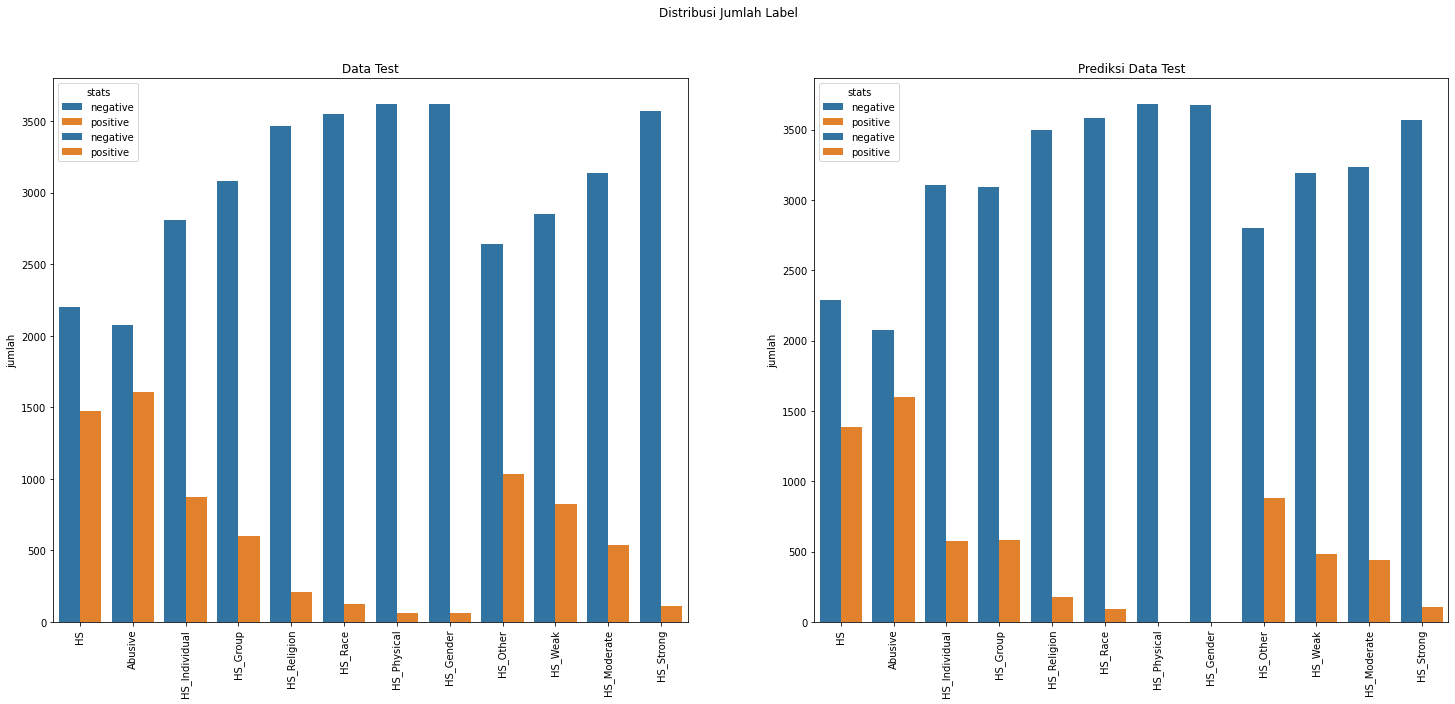

In [54]:
plt.figure(figsize=(25,10))
plt.suptitle('Distribusi Jumlah Label')

plt.subplot(1,2,1)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test).get_xticklabels(),rotation=90)
plt.title("Data Test")
plt.xlabel('')

plt.subplot(1,2,2)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test_predict).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test_predict).get_xticklabels(),rotation=90)
plt.title("Prediksi Data Test")
plt.xlabel('')

plt.show()

In [55]:
pd.DataFrame({
    "label" : data_test.columns[2:-1],
    "negative (true)" : dat_anls_test[dat_anls_test['stats'] == "negative"]["jumlah"].values,
    "positive (true)" : dat_anls_test[dat_anls_test['stats'] == "positive"]["jumlah"].values,
    "negative (predict)" : dat_anls_test_predict[dat_anls_test_predict['stats'] == "negative"]["jumlah"].values,
    "positive (predict)" : dat_anls_test_predict[dat_anls_test_predict['stats'] == "positive"]["jumlah"].values
})

,label,negative (true),positive (true),negative (predict),positive (predict)
0,HS,2204,1476,2292,1388
1,Abusive,2075,1605,2078,1602
2,HS_Individual,2806,874,3107,573
3,HS_Group,3078,602,3094,586
4,HS_Religion,3467,213,3499,181
5,HS_Race,3551,129,3585,95
6,HS_Physical,3617,63,3680,0
7,HS_Gender,3616,64,3677,3
8,HS_Other,2643,1037,2798,882
9,HS_Weak,2854,826,3195,485


### OOV Check

In [0]:
join_data_test = data_test.join(data_test_predict.drop(['Tweet','Tweet_Parsed'],axis=1),rsuffix="_predict")

In [0]:
miss_exact_tweet_test = join_data_test[(join_data_test["HS"]!=join_data_test["HS_predict"]) | (join_data_test["Abusive"] != join_data_test["Abusive_predict"]) | (join_data_test["HS_Individual"] != join_data_test["HS_Individual_predict"]) | (join_data_test["HS_Group"] != join_data_test["HS_Group_predict"]) | (join_data_test["HS_Religion"] != join_data_test["HS_Religion_predict"]) | (join_data_test["HS_Race"] != join_data_test["HS_Race_predict"]) | (join_data_test["HS_Physical"] != join_data_test["HS_Physical_predict"]) | (join_data_test["HS_Gender"] != join_data_test["HS_Gender_predict"]) | (join_data_test["HS_Other"] != join_data_test["HS_Other_predict"]) | (join_data_test["HS_Weak"] != join_data_test["HS_Weak_predict"]) | (join_data_test["HS_Moderate"] != join_data_test["HS_Moderate_predict"]) | (join_data_test["HS_Strong"] != join_data_test["HS_Strong_predict"])]

In [0]:
oov_test = oov(vocab, generate_ngrams(miss_exact_tweet_test['Tweet_Parsed']))
oov_test_count = oov_count(oov_test)

In [59]:
oov_test_count

{'ganteng': 8,
 'berengsek': 29,
 'buat': 79,
 '': 2670,
 'partaimu': 1,
 'demokrasi': 10,
 'indonesia': 299,
 'perjuangan': 7,
 'bajingan': 31,
 'mengajarkan': 1,
 'garong': 3,
 'kafir': 88,
 'kontol': 26,
 'pecun': 8,
 'hobi': 1,
 'zina': 1,
 'siap': 6,
 'berjilid': 3,
 'jilid': 3,
 'bani': 24,
 'cingkrang': 3,
 'malaysia': 129,
 'memberlakukan': 1,
 'syariat': 4,
 'melegalkan': 1,
 'perjudian': 1,
 'syarat': 1,
 'ketentuan': 1,
 'wired': 1,
 'drinker': 1,
 'jancuk': 11,
 'tabok': 2,
 'yue': 1,
 'excuse': 3,
 'kiki': 1,
 'cabean': 5,
 'charlotte': 1,
 'ronan': 1,
 'iyakan': 3,
 'jablay': 10,
 'kelemahan': 2,
 'gerindra': 4,
 'prabowo': 112,
 'elektabilitasnya': 1,
 'congor': 10,
 'fadli': 4,
 'durno': 1,
 'suffocating': 1,
 'kampungan': 43,
 'menonton': 10,
 'sampah': 19,
 'rt': 131,
 'terima': 14,
 'kasih': 21,
 'najwa': 4,
 'jakarta': 30,
 'lucu': 9,
 'banget': 69,
 'jawaban': 1,
 'ahok': 64,
 'menyambung': 5,
 'ditanya': 4,
 'kena': 9,
 'sekak': 1,
 'pertanyaan': 5,
 'isu': 19,
 '

In [60]:
print("number of OOV words : ", len(oov_test))
print("number of unique OOV words : ", len(oov_test_count))

number of OOV words :  15728
number of unique OOV words :  4608


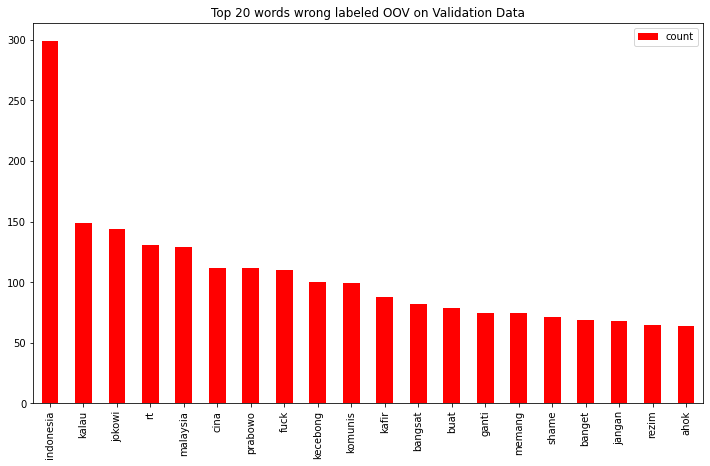

In [61]:
df_oov_test = pd.DataFrame(oov_test_count.items(),columns=["Tweet","count"])
df_oov_test.sort_values(['count'],ascending=False)[1:21].plot(
    kind='bar', y='count',x='Tweet', color='red', title='Top 20 words wrong labeled OOV on Validation Data', figsize=(12,7))
plt.xlabel("")
plt.show()

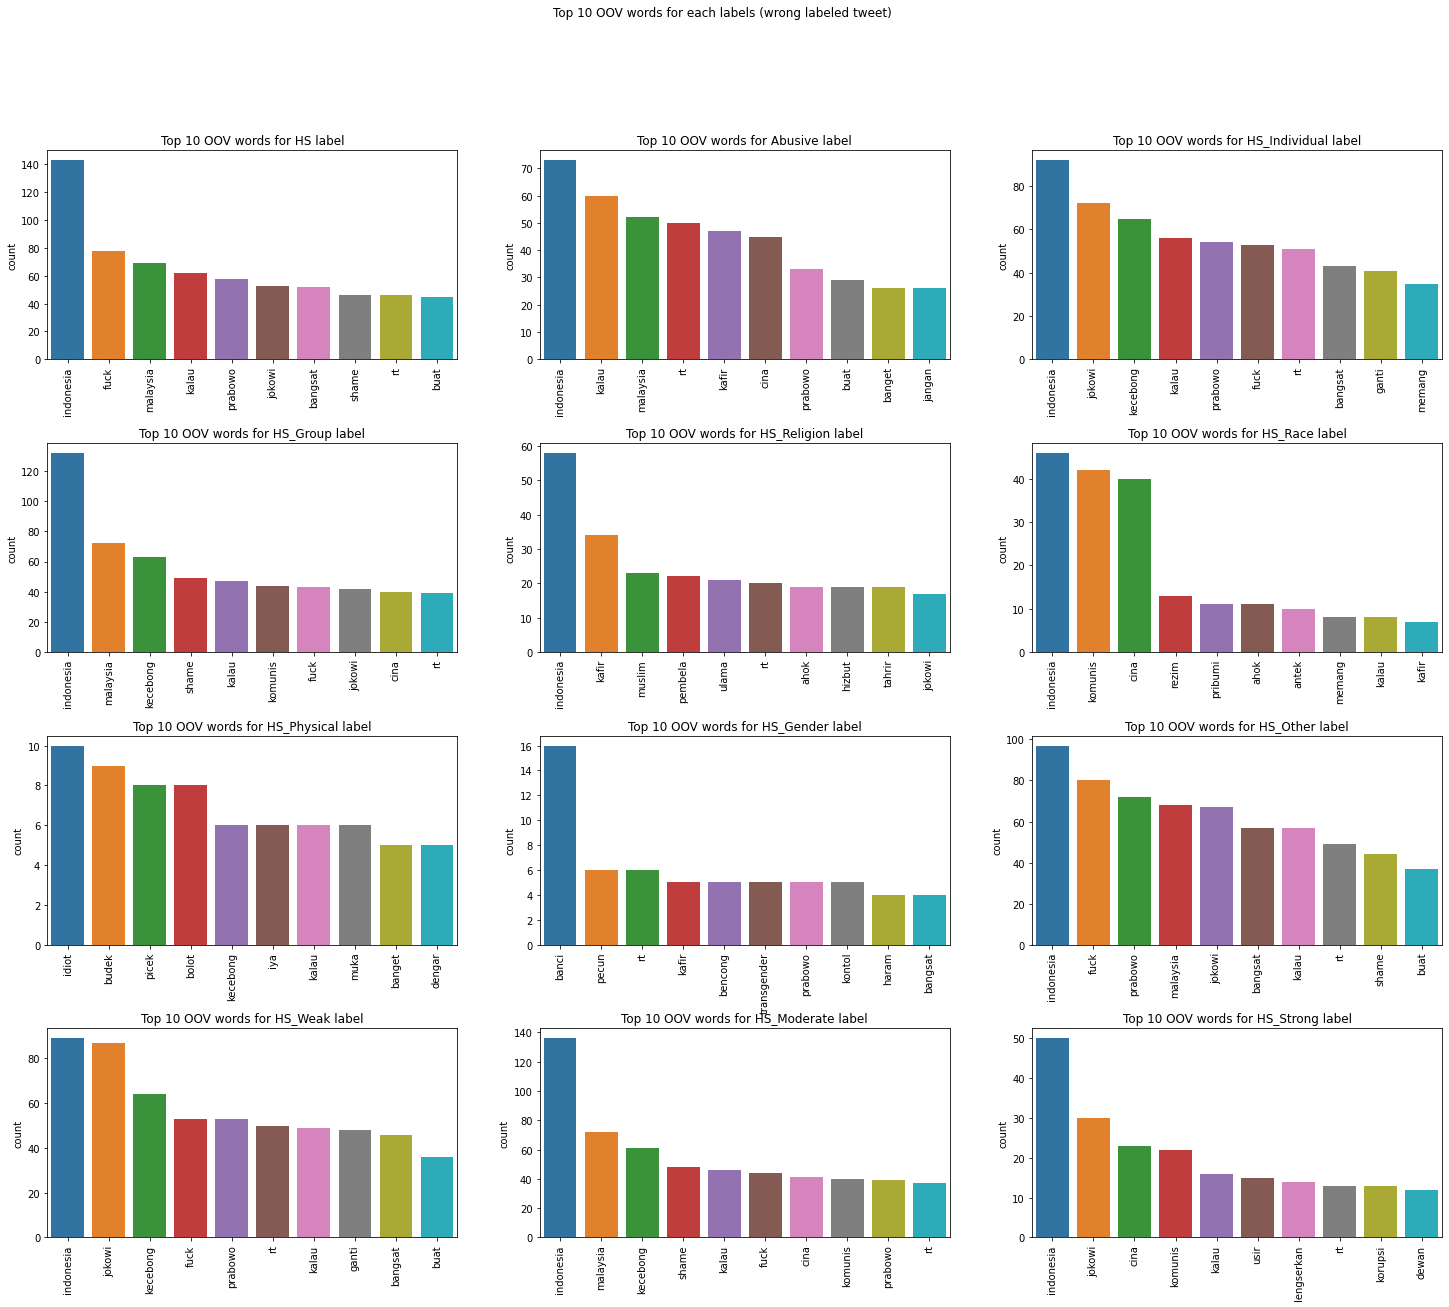

In [62]:
plt.figure(figsize=(25,20))
plt.suptitle('Top 10 OOV words for each labels (wrong labeled tweet)')
for i in range (len(target)):
    plt.subplot(4,3,i+1)
    plt.subplots_adjust(hspace=0.4)
    wrongtweet = join_data_test[join_data_test[target[i]]!=join_data_test[target[i]+str("_predict")]]
    wrongtoken = generate_ngrams(wrongtweet['Tweet_Parsed']).tolist()
    wrong_oov = oov(vocab, wrongtoken)
    wrong_oov_count = oov_count(wrong_oov)
    frame = pd.DataFrame(wrong_oov_count.items(),columns=["Tweet","count"])
    frame = frame.sort_values(['count'],ascending=False)[1:11]
    sns.barplot(x="Tweet", y="count", data=frame).set_xticklabels(sns.barplot(x="Tweet", y="count", data=frame).get_xticklabels(),rotation=90)
    title='Top 10 OOV words for '+str(target[i])+" label"
    plt.title(title)
    plt.xlabel("")

### Tweet Check

In [63]:
miss_exact_tweet_test['Tweet'].values.tolist()

["GANTENG TAPI BERENGSEK!!! BUAT APA?!!\nWHO DO YOU THINK YOU ARE? YOU'RE NOTHING!! TO ME! << REMEMBER THIS!!",
 "USER USER Karena partaimu pdip itu bajingan'",
 "USER Khan yg ngajarin si garong kafir'",
 'i might say "kontol" more often because its im in need of......',
 "USER Anak pecun... ga jauh2 dr hobi zina.. haha'",
 'USER Udah siap di demo berjilid2 sama bani cingkrang ? Malaysia memberlakukan syariat Islam, tapi melegalkan perjudian dengan berbagai syarat dan ketentuan yg "strict".\'',
 'Coffee really got me wired right now. A non coffee drinker',
 "USER Jancuk! Pingin gue tabok itu anak'",
 'Yue: i can excuse kiki and asheng becoming cabecabean but i drew a line in charlotte AND ronan having that sweet touch of a cabe',
 "USER USER USER USER USER USER iyain dah tante jablay wkwk'",
 "USER Kelemahan gerindra itu ada di orang ini,...Prabowo turun elektabilitasnya karena CONGOR fadlizon spt DURNO'",
 'indonesia: literally suffocating from the air pollution\n\nthe kampungan peopl

In [64]:
miss_exact_tweet_test['Tweet_Parsed'].values.tolist()

['ganteng tapi berengsek buat apa who do you think you are you re nothing to me remember this ',
 'user user karena partaimu partai demokrasi indonesia perjuangan itu bajingan ',
 'user   mengajarkan  garong kafir ',
 'i might say kontol more often because it is i am in need of ',
 'user anak pecun tidak jauh jauh dari hobi zina  ',
 'user sudah siap di demo berjilid jilid sama bani cingkrang malaysia memberlakukan syariat islam tapi melegalkan perjudian dengan berbagai syarat dan ketentuan  strict ',
 'coffee really got me wired right now a non coffee drinker',
 'user jancuk ingin aku tabok itu anak ',
 'yue i can excuse kiki and asing becoming cabe cabean but i drew a line in charlotte and ronan having that sweet touch of a cabe',
 'user user user user user user iyakan sudah tante jablay  ',
 'user kelemahan gerindra itu ada di orang ini prabowo turun elektabilitasnya karena congor fadli zon seperti durno ',
 'indonesia literally suffocating from the air pollution the kampungan peopl

In [65]:
miss_exact_tweet_test.iloc[:,2:-13].columns

Index(['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race',
       'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate',
       'HS_Strong'],
      dtype='object')

In [66]:
# real label
miss_exact_tweet_test.iloc[:,2:-13].values.tolist()

[[1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0],
 [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [1, 1, 1, 0, 0, 0, 0, 0,

In [0]:
miss_exact_tweet_test.to_csv("/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/bestresult_distilbert_nostemstop.csv",index=False,sep=";")